## Example: Model Titanic Survival
This example is provided to demonstrate some of the typical programming activities for working with Python in a SAS Viya environment to run actions in SAS Cloud Analytic Services. The actions that are used in the example require SAS Visual Data Mining and Machine Learning.

For more information, see http://support.sas.com/documentation/prod-p/vdmml/index.html.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [5]:
import swat
s = swat.CAS('centis', 5570)
print(s)

CAS('centis', 5570, 'sasdemo', protocol='cas', name='py-session-2', session='ad3026d8-8cba-ae40-b417-dba5f0a553ac')


## Get the Data

In [6]:
ulresult = s.upload('http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.csv')

titanic3 = ulresult.casTable

type(titanic3)

NOTE: Cloud Analytic Services made the uploaded file available as table TITANIC3 in caslib CASUSER(sasdemo).
NOTE: The table TITANIC3 has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


swat.cas.table.CASTable

In [7]:
titanic3.table.columnInfo()

,Column,ID,Type,RawLength,FormattedLength,NFL,NFD
0,pclass,1,double,8,12,0,0
1,survived,2,double,8,12,0,0
2,name,3,varchar,82,82,0,0
3,sex,4,varchar,6,6,0,0
4,age,5,double,8,12,0,0
5,sibsp,6,double,8,12,0,0
6,parch,7,double,8,12,0,0
7,ticket,8,varchar,18,18,0,0
8,fare,9,double,8,12,0,0
9,cabin,10,varchar,15,15,0,0


## Add a Computed Column
Some of the columns in the data are problematic for modeling:
* The name column should not have a bearing on the analysis.
* The boat and body columns are proxies for the response variable, survived.
* The cabin column is similar to name in that it is too specific to be generalized. A computed column, deck, is created because it is slightly more general than cabin.

In [8]:
# Create a computed variable.

titanic3.computedVars = ['deck']                         # 1
titanic3.computedVarsProgram = \
   "if cabin ne '' then deck = ksubstr(cabin,1,1); else deck = '';"


numeric=['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare']

# Remove boat and body because they are proxies for survived.
# Remove ticket and cabin. Use the computed column, deck, instead.
char = ['sex', 'deck', 'embarked', 'home.dest']

all = numeric + char

## Group By Analysis: Descriptive Statistics
The simple.summary action is used to provide some descriptive statistics. The groupBy parameter is set on the Titanic3 object so that the statistics are shown for survivors and those that did not survive.

In [9]:
# The numeric variable was defined earlier.
results = titanic3[numeric].groupby("survived").simple.summary()

resultColumns = ['Column', 'Min', 'Max', 'N', 'NMiss', 'Mean', 'Sum', 'Std', 'StdErr'];

display(HTML('<h3>Perished</h3>'))
display(results['ByGroup1.Summary'][resultColumns])       # 1

display(HTML('<h3>Survived</h3>'))
display(results['ByGroup2.Summary'][resultColumns])

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr
survived,,,,,,,,,
0,pclass,1.0,3.0,809.0,0.0,2.500618,2023.0,0.744825,0.026187
0,survived,0.0,0.0,809.0,0.0,0.000000,0.0,0.000000,0.000000
0,age,1.0,705.0,619.0,190.0,45.264943,28019.0,71.703120,2.881992
0,sibsp,0.0,8.0,809.0,0.0,0.521632,422.0,1.210449,0.042557
0,parch,0.0,9.0,809.0,0.0,0.328801,266.0,0.912332,0.032076
0,fare,0.0,2630000.0,808.0,1.0,233538.305693,188698951.0,341450.957515,12012.202768


,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr
survived,,,,,,,,,
1,pclass,1.0,3.0,500.0,0.0,1.962000,981.0,0.872972,0.039040
1,survived,1.0,1.0,500.0,0.0,1.000000,500.0,0.000000,0.000000
1,age,1.0,365.0,427.0,73.0,32.016393,13671.0,26.883023,1.300961
1,sibsp,0.0,4.0,500.0,0.0,0.462000,231.0,0.685197,0.030643
1,parch,0.0,5.0,500.0,0.0,0.476000,238.0,0.776292,0.034717
1,fare,0.0,5123292.0,500.0,0.0,493611.836000,246805918.0,686487.953065,30700.674576


## Sample the Data

In [10]:
s.builtins.loadActionSet('sampling')

# The sampling.stratified action does not accept the vars parameter.
# Instead, copyVars is used to select the columns to copy to the output table.
if 'vars' in titanic3.params:
    del titanic3.vars

# Temporarily set a groupBy parameter.
with titanic3:
    titanic3.groupBy={'survived'}
    titanic3.sampling.stratified(
       partInd=True,                                     # 1
       samppct=40,                                       # 2
       seed=1234,
       output={
          'casout':{'name':'titanic3part', 'replace':True},
          'copyVars':all
       }
    )

titanic3.table.dropTable()                               # 3

titanic3part = s.CASTable('titanic3part')                # 4
ci = titanic3part.columnInfo()
display(ci)

NOTE: Added action set 'sampling'.
NOTE: Cloud Analytic Services dropped table TITANIC3 from caslib CASUSER(sasdemo).


,Column,Label,ID,Type,RawLength,FormattedLength,NFL,NFD
0,pclass,,1,double,8,12,0,0
1,survived,,2,double,8,12,0,0
2,age,,3,double,8,12,0,0
3,sibsp,,4,double,8,12,0,0
4,parch,,5,double,8,12,0,0
5,fare,,6,double,8,12,0,0
6,sex,,7,varchar,6,6,0,0
7,deck,,8,char,15,15,0,0
8,embarked,,9,varchar,1,1,0,0
9,home.dest,,10,varchar,50,50,0,0


## Check that Sampling is Even
As long as each partition has approximately .38 for the mean, then survivor rows are distributed evenly in the partitions.

In [11]:
survSummary = titanic3part['survived'].groupby('_partind_').simple.summary()
 
resultColumns = ['Column', 'N', 'NMiss', 'Mean', 'Sum', 'Std', 'StdErr']

display(survSummary['ByGroupInfo'])
display(survSummary['ByGroup1.Summary'][resultColumns])
display(survSummary['ByGroup2.Summary'][resultColumns])

,_PartInd_,_PartInd__f,_key_
0,0.0,0,0
1,1.0,1,1


,Column,N,NMiss,Mean,Sum,Std,StdErr
_PartInd_,,,,,,,
0,survived,785.0,0.0,0.382166,300.0,0.486227,0.017354


,Column,N,NMiss,Mean,Sum,Std,StdErr
_PartInd_,,,,,,,
1,survived,524.0,0.0,0.381679,200.0,0.486263,0.021242


## Train a Model
The casOut parameter that is shown in the example is used to store the model as an in-memory table. The next step of this example is to show how to score data with the model.

In [12]:
s.builtins.loadActionSet('decisionTree')                 # 1

training = titanic3part.query('0 = _partind_')           # 2

trainingResults = training.forestTrain(
        target='survived',
        inputs=all,
        nominals=char + ['pclass', 'survived'],
        casOut={'name':'forestModel', 'replace':True},
        seed=1234,
        binOrder=True,
        varImp=True
    )

display(trainingResults)

NOTE: Added action set 'decisionTree'.


,Descr,Value
0,Anzahl Bäume,50.000000
1,Anzahl der ausgewählten Variablen (M,3.000000
2,Zufallszahlen Seed,1234.000000
3,Bootstrap Prozentwert (%),63.212056
4,Anzahl der Intervalle,20.000000
5,Anzahl Variablen,9.000000
6,Konfidenzniveau für Pruning,0.250000
7,Max Anzahl der Baumknoten,37.000000
8,Min Anzahl der Baumknoten,13.000000
9,Max Anzahl der Verzweigungen,2.000000


## Use the Model for Scoring
In this example, both the training data and the validation data are scored. This is done so that we can assess the effectiveness of the model for predicting whether someone survives on the Titanic.

The in-memory table, forestModel, is used as the model. The scoring output is stored in an in-memory table that is named forestScored.

In [13]:
forestModel = s.CASTable('forestModel')

titanic3part.forestScore(
    modelTable=forestModel, 
    copyVars=['survived', '_partind_'],
    casOut={'name':'forestScored', 'replace':True}, 
    vote='prob'
)

,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),forestScored,1309,7,"CASTable('forestScored', caslib='CASUSER(sasde..."


## Assess the Model
The assess action is part of the percentile action set. You can run the loadActionSet action to ensure that the action is available to your session.

In [14]:
s.builtins.loadActionSet('percentile')

forestScored = s.CASTable('forestScored')                # 1
forestScored.groupBy='_PartInd_'                         # 2
forestScored.computedVars=['P1', 'P0']                   # 3
forestScored.computedVarsProgram='''                     
   if '1' eq strip(_RF_PredName_) then do;
     P1 = _RF_PredP_;
     P0 = 1 - _RF_PredP_;
   end;
   else do;
     P1 = 1 - _RF_PredP_;
     P0 = _RF_PredP_;
   end;
'''                                                      # 4

forestScored.percentile.assess(
    casOut={'name':'forestAssess', 'replace':True},
    nbins=10,
    cutStep = 0.01,
    inputs=['P1'],
    response='survived', 
    event='1', 
    pVar=['P0'], 
    pEvent='0'
)

NOTE: Added action set 'percentile'.


,casLib,Name,Rows,Columns,casTable
0,CASUSER(sasdemo),forestAssess,20,23,"CASTable('forestAssess', caslib='CASUSER(sasde..."
1,CASUSER(sasdemo),forestAssess_ROC,200,22,"CASTable('forestAssess_ROC', caslib='CASUSER(s..."
2,CASUSER(sasdemo),forestAssess_FITSTAT,2,8,"CASTable('forestAssess_FITSTAT', caslib='CASUS..."


## Plot ROC

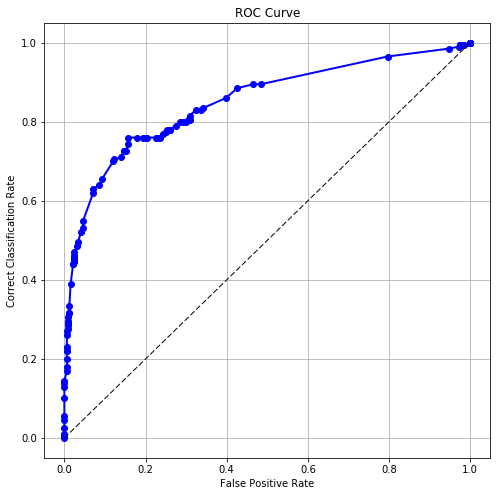

In [15]:
forestAssess_ROC = \
    s.CASTable('forestAssess_ROC', where='1 = _partind_') # 1

out2 = forestAssess_ROC.to_frame()

plt.figure(figsize=(8,8))
plt.plot(out2._FPR_,out2._Sensitivity_,'bo-',linewidth=2)
plt.plot(pd.Series(range(0,11,1))/10,pd.Series(range(0,11,1))/10,'k--',linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('Correct Classification Rate')
plt.grid(True)
plt.title('ROC Curve')
plt.show()

## Plot Lift

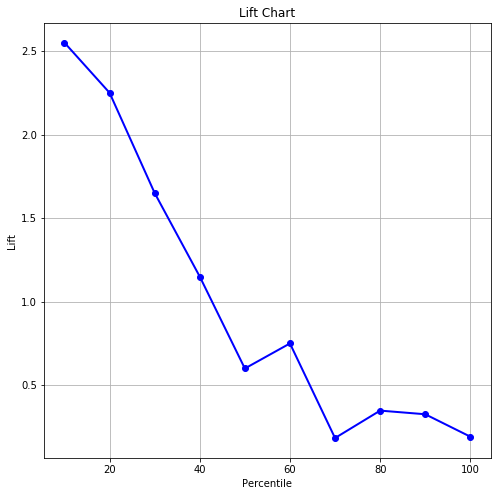

In [16]:
forestAssess = \
     s.CASTable('forestAssess', where='1 = _partind_')  # 1
lift = forestAssess.to_frame()

plt.figure(figsize=(8,8))
plt.plot(lift._Depth_, lift._Lift_,'bo-',linewidth=2)
plt.xlabel('Percentile')
plt.ylabel('Lift')
plt.grid(True)
plt.title('Lift Chart')
plt.show()


In [17]:
s.close()

Copyright SAS Institute

Disclaimer: SAS may reference other websites or content or resources for use at Customer's sole discretion. SAS has no control over any websites or resources that are provided by companies or persons other than SAS. Customer acknowledges and agrees that SAS is not responsible for the availability or use of any such external sites or resources, and does not endorse any advertising, products, or other materials on or available from such websites or resources. Customer acknowledges and agrees that SAS is not liable for any loss or damage that may be incurred by Customer or its end users as a result of the availability or use of those external sites or resources, or as a result of any reliance placed by Customer or its end users on the completeness, accuracy, or existence of any advertising, products, or other materials on, or available from, such websites or resources.